# CHAPTER 3 - CLASSIFICATION WITH THE MNIST DATASET
On this chapter is all about classification. We will be exploring the MNIST dataset which contains arrays of pizels as feature and numbers as labels.

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
X, y = mnist['data'], mnist['target']

#### Printing one number

In [4]:
import matplotlib
import matplotlib.pyplot as plt

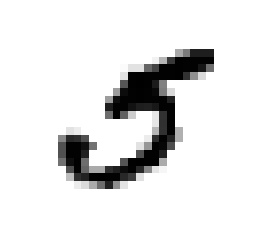

In [5]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [6]:
# this function is used on the chapter for easy plotting of the digits
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

### Splitting between training and test

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let's shuffle the values to make sure the same numbers dont get overrepresented when doing k-folds

In [8]:
import numpy as np

In [9]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Creating a binary classifier
Let's start building a small use case to predict only one number.

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

We will be using SDG = Stochastic Gradient Descent. This classifier can process a lot of data and it can only compute instances independelty (good for online learning) https://en.wikipedia.org/wiki/Stochastic_gradient_descent

In [10]:
from sklearn.linear_model import SGDClassifier

In [11]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

## Performace Measures
There are multiple performance metrics for classification models. 

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96325, 0.96695, 0.9652 ])

At first it looks like a great classifier, however, there are not really many 5 in our dataset. So, even predicting not a 5 all the time would have good accuracy (about 90%)

In [16]:
np.sum(y_train != 5) / len(y_train) 

0.90965

Sometimes accuracy might not really be the best performance metric with skewed data like the mnist dataset.

### Confusion Matrix
We will be using cross_val_predict which outputs the prediction instead of the scores

In [17]:
from sklearn.model_selection import cross_val_predict
y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_predict)

array([[54106,   473],
       [ 1619,  3802]])

The first row is for those that are not your class. The first column are predicted right, and those in the left are those that were wrongly classified as 5. The second row are those that are actually 5, the first column (left) are those that were not classified as 5 and those in the right are those correctly classified as 5.

### Precision and Recall
These 2 metrics are useful in classification because they can tell you relative information about your prediction. Precision is proportion of correct prediction of your class, while recall is proportion of detected class out of your true values.

In [19]:
from sklearn.metrics import recall_score, precision_score

In [20]:
precision_score(y_train_5, y_train_predict)

0.8893567251461988

In [21]:
recall_score(y_train_5, y_train_predict)

0.7013466150156797

In this case, when the prediction is 5, it's only accurate 89% of the times and it identifies 5 correclty only 70% of the times.
Another convenient metric is **F1 score** which combines precision and recall

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_predict)

0.7842409240924091

We could also get the scores of the prediction instead of the predicted value. This will allow us to make whatever tradeoff we want to makre.

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([22813.78355811])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
threshold = 300000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [38]:
# get all scores of the predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [39]:
# hack to work around issue #9589 in Scikit-Learn 0.19.0
# this is because the y_scores has an extra column that is not passed well to precision_recall_curve
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [40]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [45]:
def plot_prediction_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])
    plt.xlim([-700000, 700000])

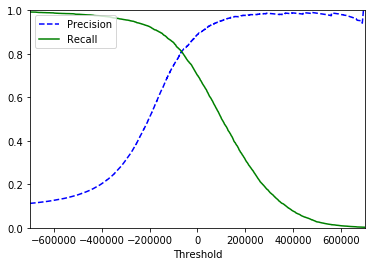

In [46]:
plot_prediction_recall_vs_threshold(precisions, recalls, thresholds)

### The ROC Curve (Receiver operating characteristic)
Sensitivity (recall) vs 1 - specificity 

In [47]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [52]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

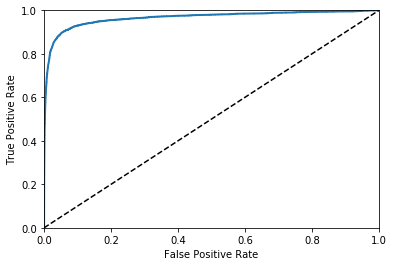

In [53]:
plot_roc_curve(fpr, tpr)

In [54]:
# we can as well compare the Area Under the Curve ROC AUC score. 1 would be a perfect classifier
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9656064754511583

We can compare this retuls to what we would get from a Random Forest Classifier. However, the RFC would not contain a decision function as SGD does. Instead we would use predict_proba to get the scores.

In [55]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [57]:
# This will output 2 scores, one for each class. In our case, it would be one for non-5 and one for 5. 
y_probas_forest

array([[0.4, 0.6],
       [1. , 0. ],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

In [58]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

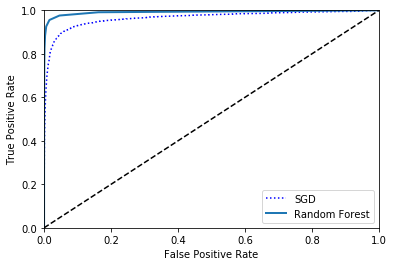

In [60]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')

In [61]:
roc_auc_score(y_train_5, y_scores_forest)

0.9919133498194067

### Multiclass Classification
Let's try now classifying multiple classes as in our example.
It's important to note that some classifiers are binary classifiers that can only predict one class. When this happens, we can use 2 startegies:
* OvA: We create one classifier for each class and select the highest score from all the classifiers
* OvO: We create pairs of classifiers and compare one class vs other. The con here is that you need many more classifiers

Others classifiers work with multiclasses like: Random Forest or Naive Bayes

In [62]:
# running SGD. Since SGD is a binary classifier, it will create 10 different classifiers automatically and select the one with the higuest score
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

In [63]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-123457.51796481, -517653.41619772, -293456.15603101,
        -120004.29722357, -332381.70928289,   22813.78355811,
        -633035.87311467, -260139.90946639, -740524.85292859,
        -602568.87928713]])

In [64]:
# argmax will return the index of the highest score
np.argmax(some_digit_scores)

5

SGD will use OvA strategy. But you can force it to use OvO by calling sklearn.multiclass.OneVsOneClassifier.

Now, let's use Random Forest Classifier which can predict into multiple classes

In [65]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [66]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. ]])

Let's compare the errors. Alone and with scaling

In [67]:
# Alone
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.85217956, 0.8640432 , 0.85442816])

In [69]:
# With Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.91131774, 0.91134557, 0.90893634])

### Error Analysis
Let's see how the errors look for each class

In [70]:
y_train_predict = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_predict)
conf_mx

array([[5744,    4,   35,   12,   21,    9,   32,   10,   47,    9],
       [   1, 6315,   70,   36,   30,    2,    5,   82,  197,    4],
       [  66,  105, 5121,  165,   84,   13,   76,   79,  229,   20],
       [  68,   44,  153, 5421,   24,   45,   37,   66,  186,   87],
       [  17,   72,   40,   39, 5072,    9,   26,   55,  169,  343],
       [ 230,   84,   73,  585,  177, 3255,  166,   71,  644,  136],
       [  87,   42,  143,   28,   65,   48, 5414,   10,   77,    4],
       [  42,   49,   81,   69,   52,    5,    6, 5705,   29,  227],
       [  55,  352,   77,  267,   91,   79,   35,   61, 4707,  127],
       [  68,   96,   32,  174,  313,   30,    0,  400,  177, 4659]])

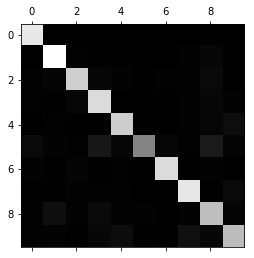

In [71]:
# and we can plat them into a grid
# matplot will take the resuls which are absolute numbers
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [72]:
#We can try to normalize the errors by the total numbers of instances in a class
row_sums = conf_mx.sum(axis=1, keepdims=True)
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

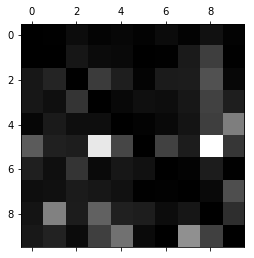

In [74]:
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

A lot of 5s are classified as either 3 or 8s. In the book, the author explains how this model is using pixel positioning rather than the position relative to each other. So, centered and well aligned numbers might have a smaller misclassification error.

### Multilabel Classification
This is used when you have multiple classifiers on the same data. In pictures, you can have one that recognizes the faces of multiple people per image. In this case, let's look an example where it classifies large numbers and odd numbers concurrently using **KNeighborsClassfier**

In [15]:
from sklearn.neighbors import KNeighborsClassifier

In [13]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel

array([[False,  True],
       [False, False],
       [False,  True],
       ...,
       [False,  True],
       [False, False],
       [False, False]])

In [16]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

A method to measure performance of multilabel classifiers is to compute the F1 Score for each classifier and average them.

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average='macro')
# I could use average='weighted' if I want to weight the scores by its support (number of instances of the class)

### Multioutput Classification
This is is generalization where the output could contain multiple predictions. In this example, we will take the images as input with noise, and the output will be the actual image. In this case, the output will be the pixel (as labels) and the intensity. These would be almost a classifier combined with a regressor.

In [11]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

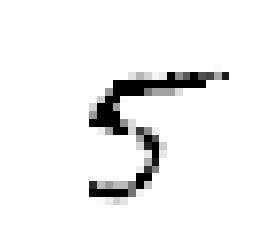

In [18]:
# now let's train the classifier , regressor
some_index = 5500
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

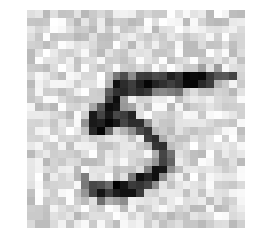

In [20]:
plot_digit(X_test_mod[some_index])